<a href="https://colab.research.google.com/github/NikNord174/Classic_ML/blob/main/Optimal%20Coordinates%20for%20Add%20Banners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение оптимальных мест расположения рекламных баннеров

Необходимо расположить 20 тестовых баннеров в 20 локациях по всему миру. Баннеры должны располагаться:

1) в местах скопления людей (на основании результатов чекапов сети Foursquare);

2) вблизи офисов заказчиков.

Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас.

С помощью pandas построим DataFrame и убедимся, что все 396634 строки с координатами считаны успешно.

###Импортируем необходимые библиотеки

In [ ]:
!pip install geopandas

In [1]:
import pandas as pd
from sklearn.cluster import MeanShift
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib

### Готовим данные

In [2]:
!wget https://archive.org/download/201309_foursquare_dataset_umn/fsq.zip

--2022-03-15 20:56:46--  https://archive.org/download/201309_foursquare_dataset_umn/fsq.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia903009.us.archive.org/10/items/201309_foursquare_dataset_umn/fsq.zip [following]
--2022-03-15 20:56:47--  https://ia903009.us.archive.org/10/items/201309_foursquare_dataset_umn/fsq.zip
Resolving ia903009.us.archive.org (ia903009.us.archive.org)... 207.241.233.19
Connecting to ia903009.us.archive.org (ia903009.us.archive.org)|207.241.233.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160737760 (153M) [application/zip]
Saving to: ‘fsq.zip’

fsq.zip             100%[===================>] 153.29M   178KB/s    in 10m 37s 

2022-03-15 21:07:26 (246 KB/s) - ‘fsq.zip’ saved [160737760/160737760]



In [3]:
!unzip /content/fsq.zip

Archive:  /content/fsq.zip
   creating: umn_foursquare_datasets/
  inflating: umn_foursquare_datasets/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/umn_foursquare_datasets/
  inflating: __MACOSX/umn_foursquare_datasets/._.DS_Store  
  inflating: umn_foursquare_datasets/checkins.dat  
  inflating: umn_foursquare_datasets/ratings.dat  
  inflating: __MACOSX/umn_foursquare_datasets/._ratings.dat  
  inflating: umn_foursquare_datasets/socialgraph.dat  
  inflating: umn_foursquare_datasets/users.dat  
  inflating: umn_foursquare_datasets/venues.dat  


In [139]:
data=pd.read_csv('/content/umn_foursquare_datasets/checkins.dat', sep='|')
data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,user_id,venue_id,latitude,longitude,created_at
0,---------+---------+----------+---------------...,NaN,NaN,NaN,NaN,NaN
1,984301,2041916.0,5222.0,,,2012-04-21 17:39:01
2,984222,15824.0,5222.0,38.8951118,-77.0363658,2012-04-21 17:43:47
3,984315,1764391.0,5222.0,,,2012-04-21 17:37:18
4,984234,44652.0,5222.0,33.800745,-84.41052,2012-04-21 17:43:43
...,...,...,...,...,...,...
1021963,956119,1139114.0,29488.0,42.439479,-83.7438303,2012-04-13 11:36:44
1021964,956447,2088020.0,4432.0,,,2012-04-13 12:58:05
1021965,956733,960666.0,60.0,42.331427,-83.0457538,2012-04-13 21:56:19
1021966,957139,1771518.0,10935.0,,,2012-04-14 02:44:52


Очищаем данные от строк с неопределенными координатами.

In [5]:
df= data.loc[data.loc[:,'     longitude     '] != data.loc[3,'     longitude     ']]
df=df.dropna(subset=['     longitude     '])
df

,id,user_id,venue_id,latitude,longitude,created_at
2,984222,15824.0,5222.0,38.8951118,-77.0363658,2012-04-21 17:43:47
4,984234,44652.0,5222.0,33.800745,-84.41052,2012-04-21 17:43:43
8,984291,105054.0,5222.0,45.5234515,-122.6762071,2012-04-21 17:39:22
10,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
11,984232,93870.0,380645.0,33.4483771,-112.0740373,2012-04-21 17:38:18
...,...,...,...,...,...,...
1021960,955561,626076.0,20073.0,40.8501002,-73.8662464,2012-04-13 09:56:48
1021961,955892,674797.0,2297.0,33.7489954,-84.3879824,2012-04-13 10:56:03
1021962,956377,845102.0,11195.0,42.7653662,-71.467566,2012-04-13 12:08:45
1021963,956119,1139114.0,29488.0,42.439479,-83.7438303,2012-04-13 11:36:44


### Кластеризация MeanShift

Кластеризируем отобранные координаты, чтобы выявить центры скоплений туристов. Учтем, что баннеры имеют ограниченный радиус действия. Для этого используем алгоритм клстеризации MeanSchift. Для простоты условимся, что эффективность баннеров распространяется на 5-10км. При переводе в градусы долготы и широты получится bandwidth=0.1.

In [8]:
columns=df.columns[3:5]
X=df.loc[:,columns][:100000]
ms = MeanShift(bandwidth=0.1).fit(X)

,latitude,longitude
2,38.8951118,-77.0363658
4,33.800745,-84.41052
8,45.5234515,-122.6762071
10,40.764462,-111.904565
11,33.4483771,-112.0740373
...,...,...
233789,33.575,-117.7255556
233790,37.629349,-122.400087
233794,29.7628844,-95.3830615
233798,32.802955,-96.769923


Некоторые из полученных кластеров будут содержать слишком мало точек, то есть в таких местах проходит мало людей. Очевидно, что такие кластеры не интересны с точки зрения установки  баннеров. Поэтому определим кластеры, содержащие, например, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

In [141]:
clusters=ms.labels_
centers=ms.cluster_centers_

In [143]:
preds=pd.DataFrame(clusters)
ans=X.reset_index()
ans=pd.concat([ans, preds],axis=1)
ans=ans.drop(['index'],axis=1)
ans.set_axis(['latitude','longtitude','preds'], axis='columns', inplace=True)

In [144]:
for i in np.unique(clusters):
    ans_new=ans.loc[ans.loc[:,'preds']==i]
    if ans_new.shape[0]<=15:
        ans=ans.drop(ans_new.index)
ans

,latitude,longtitude,preds
0,38.8951118,-77.0363658,5
1,33.800745,-84.41052,7
2,45.5234515,-122.6762071,30
3,40.764462,-111.904565,65
4,33.4483771,-112.0740373,1
...,...,...,...
99995,33.575,-117.7255556,50
99996,37.629349,-122.400087,4
99997,29.7628844,-95.3830615,25
99998,32.802955,-96.769923,19


In [146]:
coordinates=ms.cluster_centers_[ans['preds'].unique()]

Так мы определили оптимальные местоположения баннеров с учетом наибольшей людности.

### Поиск оптимальных мест установки баннеров, вблизи офисов компании

Координаты офисов:

In [125]:
la=np.array([33.751277, -118.188740])# (Los Angeles)

miami=np.array([25.867736, -80.324116])# (Miami)

london=np.array([51.503016, -0.075479])# (London)

amst=np.array([52.378894, 4.885084])# (Amsterdam)

beijing=np.array([39.366487, 117.036146])# (Beijing)

sydney=np.array([-33.868457, 151.205134])# (Sydney)
cities=['LA','Miami','London','Amsterdam','Beijing','Sydney']

In [59]:
offices=[[33.751277, -118.188740],
[25.867736, -80.324116],
[51.503016, -0.075479],
[52.378894, 4.885084],
[39.366487, 117.036146],
[-33.868457, 151.205134]]

In [145]:
from numpy.linalg import norm
d=norm(offices[0] - miami, ord=2)
a=[]
a.append([offices[0],d])
d1=norm(offices[2] - miami, ord=2)
a.append([offices[2],d1])

In [126]:
a=[]
for office in range(len(offices)):
    for center in coordinates:
      dist=norm(offices[office] - center, ord=2)
      a.append([center[0],center[1], abs(dist),cities[office]])
a=pd.DataFrame(a,columns=['latitude','longtitude','distance','city'])

In [127]:
banners=a.sort_values(by=['distance'],ignore_index=True).iloc[:20,:]
banners

,latitude,longtitude,distance,city
0,-33.860630,151.204776,0.007835,Sydney
1,52.372964,4.892317,0.009353,Amsterdam
2,25.845672,-80.318891,0.022674,Miami
3,51.502991,-0.125537,0.050058,London
4,33.809878,-118.148924,0.070848,LA
5,25.785812,-80.217938,0.134109,Miami
6,25.705350,-80.283429,0.167406,Miami
7,26.010098,-80.199991,0.188876,Miami
8,33.888325,-118.048928,0.195779,LA
9,33.872986,-118.362091,0.211811,LA


### Визуализация мест установки

[<shapely.geometry.point.Point object at 0x7ff2a125c490>, <shapely.geometry.point.Point object at 0x7ff2a03db250>, <shapely.geometry.point.Point object at 0x7ff2a342d050>, <shapely.geometry.point.Point object at 0x7ff2a342df50>, <shapely.geometry.point.Point object at 0x7ff2a342d650>, <shapely.geometry.point.Point object at 0x7ff2a342d250>, <shapely.geometry.point.Point object at 0x7ff2a342d350>, <shapely.geometry.point.Point object at 0x7ff2a342dcd0>, <shapely.geometry.point.Point object at 0x7ff2a342da90>, <shapely.geometry.point.Point object at 0x7ff2a342d390>, <shapely.geometry.point.Point object at 0x7ff2a342d1d0>, <shapely.geometry.point.Point object at 0x7ff2a342d190>, <shapely.geometry.point.Point object at 0x7ff2a342d210>, <shapely.geometry.point.Point object at 0x7ff2a342da50>, <shapely.geometry.point.Point object at 0x7ff2a342d490>, <shapely.geometry.point.Point object at 0x7ff2a342df90>, <shapely.geometry.point.Point object at 0x7ff2a342d950>, <shapely.geometry.point.Point 

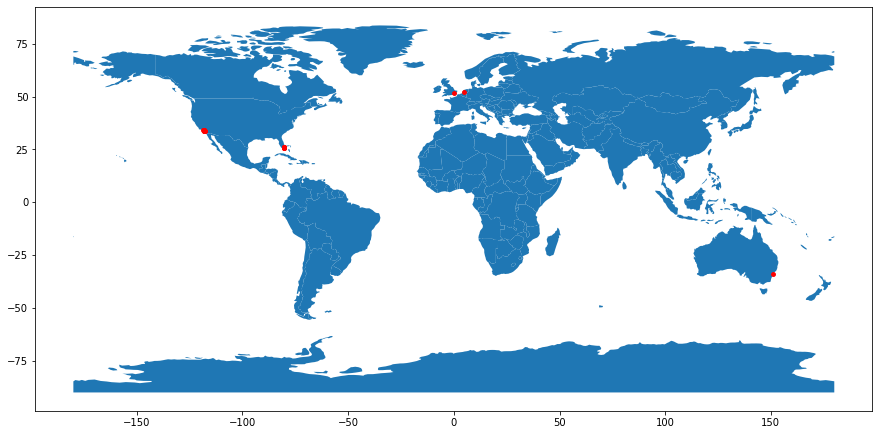

In [138]:
geometry = [Point(xy) for xy in zip(banners['longtitude'],banners['latitude'])]
gdf = GeoDataFrame(banners, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 10)), marker='o', color='red', markersize=15);

Как видно из карты, оптимальные маста для установки тестовых баннеров - Лос-Анжелес, Майами, Лондон, Амстердам, Сидней.